#### Libraries

In [1]:
import pandas as pd
import numpy as np
import backtesting_base_mostoro as back
from datetime import time
from datetime import time, timedelta


In [2]:

#Parameters to get data from backtesting base class
year = 2025
symbol = 'MES'
# start  = '2023-10-15' # it could be useful to fiter the data
# end    = '2023-10-27' # it could be useful to fiter the data
amount = 5000
bar_time = '1min'
stop_loss = 4
target = 8
#Calling backtesting base class to get some variables
backtesting_base = back.Backtesting(symbol, amount, bar_time, stop_loss, target) # calling backtesting base
data_intraday = backtesting_base.data


MES Data Loaded! (in backtesting base)


In [3]:
data_intraday

,open,high,low,close,Bid_Volume,Ask_Volume,Volume
Date,,,,,,,
2025-04-01 18:00:00,5672.00,5674.50,5671.75,5674.00,225,378,603
2025-04-01 18:01:00,5674.50,5677.00,5673.75,5675.50,217,105,322
2025-04-01 18:02:00,5675.00,5676.25,5675.00,5675.75,71,90,161
2025-04-01 18:03:00,5676.25,5676.25,5675.25,5675.50,46,68,114
2025-04-01 18:04:00,5675.50,5676.25,5675.50,5676.00,66,25,91
...,...,...,...,...,...,...,...
2025-07-23 16:55:00,6404.75,6406.25,6404.50,6405.75,213,101,314
2025-07-23 16:56:00,6405.75,6406.50,6405.00,6406.50,63,78,141
2025-07-23 16:57:00,6406.00,6407.00,6405.75,6406.50,54,58,112


### Strategy

In [4]:
# # # --- Ventana operativa (usa el huso del índice de df.index) ---
# # TRADE_START = time(8, 30)
# # TRADE_END   = time(17, 00)

# # def in_window(ts) -> bool:
# #     # Funciona con índices naïve o tz-aware (tomando la hora "tal cual" del índice)
# #     tt = pd.Timestamp(ts).time()
# #     return (TRADE_START <= tt <= TRADE_END)

# WINDOWS = [
#     (time(8, 30), time(10, 30)),  # morning
#     (time(15, 0), time(17, 0)),   # close
# ]

# def in_window(ts) -> bool:
#     tt = pd.Timestamp(ts).time()
#     return any(start <= tt <= end for start, end in WINDOWS)


# # --- Blocking new entries after 12 pm

# # session_blocked      = {}  # {date: bool} -> True = no más entradas ese día
# # session_wait_to_lock = {}  # {date: bool} -> True = hay pos. abierta post 12; bloquear cuando cierre

# # def can_enter(ts) -> bool:
# #     sdate = pd.Timestamp(ts).date()
# #     return (not session_blocked.get(sdate, False)) and in_window(ts)


# def can_enter(ts) -> bool:
#     return in_window(ts)


# # ------- Strategy Params -------
# TICK_SIZE        = 0.25     # MES
# WITHIN_TICKS     = 5       # 0 = must tag the prior extreme; >0 = allow proximity
# FLAT_AT_DAY_END  = True
# CONTRACTS        = 1
# # -------------------------------

# # If you want to hard-silence any remaining library warnings (optional):
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# # Source data from your Backtesting instance
# df = backtesting_base.data.copy()
# df.index = pd.to_datetime(df.index).sort_values()

# # Delta & bar color
# df['delta'] = df['Ask_Volume'] - df['Bid_Volume']
# df['red']   = df['close'] < df['open']
# df['green'] = df['close'] > df['open']

# # Session key
# df['session'] = df.index.date

# # --- Developing intraday extremes up to the PREVIOUS bar (no look-ahead) ---
# # Avoid GroupBy.apply (causes deprecation warning). Do it column-wise:
# day_high_running = df['high'].groupby(df['session']).cummax()
# day_low_running  = df['low'].groupby(df['session']).cummin()

# # Shift PER SESSION
# df['day_high_prev'] = day_high_running.groupby(df['session']).shift(1)
# df['day_low_prev']  = day_low_running.groupby(df['session']).shift(1)

# # # Trigger when *this bar* is at/near those previous extremes
# # near = WITHIN_TICKS * TICK_SIZE
# # at_or_near_high = df['day_high_prev'].notna() & (df['high'] >= df['day_high_prev'] - near)
# # at_or_near_low  = df['day_low_prev'].notna()  & (df['low']  <= df['day_low_prev']  + near)

# # # Valtos-style exhaustion (divergence feel): tag high with red+neg-delta, tag low with green+pos-delta
# # df['short_sig'] = at_or_near_high & df['red']   & (df['delta'] < 0)
# # df['long_sig']  = at_or_near_low  & df['green'] & (df['delta'] > 0)



# # --- VALID WHEN: new day high/low OR within ≤ WITHIN_TICKS of prior extreme ---
# near = WITHIN_TICKS * TICK_SIZE  # e.g., 4 ticks on MES = 1.0 point

# new_high = df['high'] >= df['day_high_prev']                   # tags/sets new high
# near_high = (df['day_high_prev'] - df['high']).between(0, near)  # ≤ near below high
# at_or_near_high = df['day_high_prev'].notna() & (new_high | near_high)

# new_low = df['low'] <= df['day_low_prev']                      # tags/sets new low
# near_low = (df['low'] - df['day_low_prev']).between(0, near)     # ≤ near above low
# at_or_near_low  = df['day_low_prev'].notna() & (new_low | near_low)

# # Valtos-style divergence filter
# df['short_sig'] = at_or_near_high & df['red']   & (df['delta'] < 0)
# df['long_sig']  = at_or_near_low  & df['green'] & (df['delta'] > 0)




# # --------- Backtest loop using your class ----------
# idx = df.index.to_list()

# for i in range(1, len(idx)):
#     t_prev, t = idx[i-1], idx[i]
#     prev, bar = df.loc[t_prev], df.loc[t]

#     # 1) Manage exits for open position using current bar intrabar range
#     if backtesting_base.position == 1:  # LONG
#         stop   = backtesting_base.profit.Stop.iloc[-1]
#         target = backtesting_base.profit.Target.iloc[-1]
#         if bar['low'] <= stop:
#             backtesting_base.place_order(direction='Short', price=stop,   contracts=CONTRACTS, time=t)
#         elif bar['high'] >= target:
#             backtesting_base.place_order(direction='Short', price=target, contracts=CONTRACTS, time=t)

#     elif backtesting_base.position == -1:  # SHORT
#         stop   = backtesting_base.profit.Stop.iloc[-1]
#         target = backtesting_base.profit.Target.iloc[-1]
#         if bar['high'] >= stop:
#             backtesting_base.place_order(direction='Long', price=stop,   contracts=CONTRACTS, time=t)
#         elif bar['low'] <= target:
#             backtesting_base.place_order(direction='Long', price=target, contracts=CONTRACTS, time=t)




#     if backtesting_base.position == 0 and can_enter(t):
#             if prev['short_sig']:
#                 backtesting_base.place_order(direction='Short', price=bar['open'], contracts=CONTRACTS, time=t)
#             elif prev['long_sig']:
#                 backtesting_base.place_order(direction='Long',  price=bar['open'], contracts=CONTRACTS, time=t)




#     # 2) Entries when flat — use PREVIOUS bar's signal; enter at THIS bar open
#     # if backtesting_base.position == 0:
#     #     if prev['short_sig']:
#     #         backtesting_base.place_order(direction='Short', price=bar['open'], contracts=CONTRACTS, time=t)
#     #     elif prev['long_sig']:
#     #         backtesting_base.place_order(direction='Long',  price=bar['open'], contracts=CONTRACTS, time=t)









#     # if backtesting_base.position != 0 and (prev_time < TRADE_END <= curr_time):
#     #         # Cierra al close del bar actual de las 12:00 (o primero que la cruce)
#     #         if backtesting_base.position == 1:
#     #             backtesting_base.place_order(direction='Short', price=bar['close'], contracts=CONTRACTS, time=t)
#     #         else:
#     #             backtesting_base.place_order(direction='Long',  price=bar['close'], contracts=CONTRACTS, time=t)





#     # 3) Optional: flatten at end of day
#     if FLAT_AT_DAY_END:
#         is_last_of_day = (i == len(idx)-1) or (df.loc[idx[i+1], 'session'] != bar['session'])
#         if is_last_of_day and backtesting_base.position != 0:
#             if backtesting_base.position == 1:
#                 backtesting_base.place_order(direction='Short', price=bar['close'], contracts=CONTRACTS, time=t)
#             else:
#                 backtesting_base.place_order(direction='Long',  price=bar['close'], contracts=CONTRACTS, time=t)

# # Results
# display(backtesting_base.profit.tail())
# backtesting_base.metrics()


,Instrument,Direction,Contracts,Commision,Price,Stop,Target,Time,Position,Profit,%_Profit
433,MES,Long,1,0.82,6397.25,0.00,0.00,2025-07-23 16:03:00,0,-21.64,-0.003385
434,MES,Short,1,0.82,6396.50,6400.50,6388.50,2025-07-23 16:04:00,-1,0,0.000000
435,MES,Long,1,0.82,6400.50,0.00,0.00,2025-07-23 16:12:00,0,-21.64,-0.003383
436,MES,Short,1,0.82,6405.25,6409.25,6397.25,2025-07-23 16:45:00,-1,0,0.000000
437,MES,Long,1,0.82,6405.75,0.00,0.00,2025-07-23 16:59:00,0,-4.14,-0.000646


--------------------------------------------------
net profit: 279.98
profit_factor: 1.10
max_drawdown: -6.0%
annualized_sharpe_ratio: 0.63
annualized_sortino_ratio: 13.65
annualized_ulcer_index: 0.44
annualized_upi: 733.40
percentaje_profitable: 37.90
--------------------------------------------------


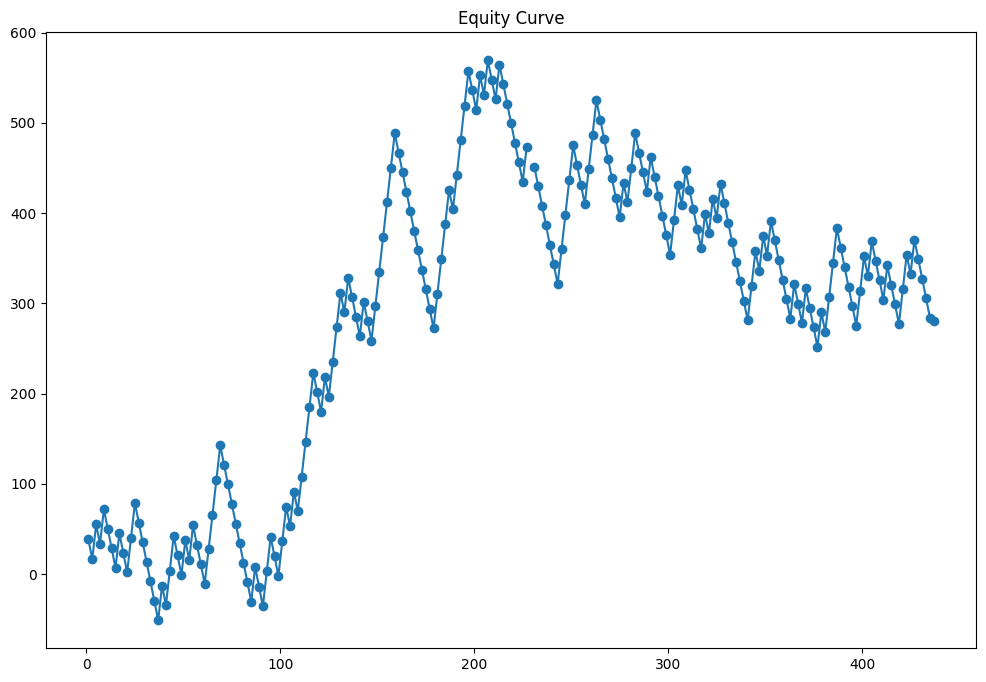

In [5]:
# ======================= Session window & helpers =======================
from datetime import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# --- Trading windows (use the timezone already embedded in df.index) ---
WINDOWS = [
    (time(8, 30), time(10, 30)),  # morning
    (time(15, 0), time(17, 0)),   # close
]

def in_window(ts) -> bool:
    tt = pd.Timestamp(ts).time()
    return any(start <= tt <= end for start, end in WINDOWS)

def can_enter(ts) -> bool:
    return in_window(ts)

# ------- Strategy params -------
TICK_SIZE        = 0.25     # MES
WITHIN_TICKS     = 5        # 0 = must tag prior extreme; >0 = allow proximity
FLAT_AT_DAY_END  = True
CONTRACTS        = 1
# -------------------------------

# ======================= Data preparation =======================
# Source data from your Backtesting instance
df = backtesting_base.data.copy()
df.index = pd.to_datetime(df.index).sort_values()

# Delta & bar color
df['delta'] = df['Ask_Volume'] - df['Bid_Volume']
df['red']   = df['close'] < df['open']
df['green'] = df['close'] > df['open']

# Session key (by calendar date in index)
df['session'] = df.index.date

# --- Developing intraday extremes up to the PREVIOUS bar (no look-ahead) ---
day_high_running = df['high'].groupby(df['session']).cummax()
day_low_running  = df['low'].groupby(df['session']).cummin()

# Shift PER SESSION (so each bar only sees prior info)
df['day_high_prev'] = day_high_running.groupby(df['session']).shift(1)
df['day_low_prev']  = day_low_running.groupby(df['session']).shift(1)

# ======================= Extreme proximity flags =======================
near = WITHIN_TICKS * TICK_SIZE  # e.g., 5 ticks on MES = 1.25 points

new_high     = df['high'] >= df['day_high_prev']                       # tags/sets new high
near_high    = (df['day_high_prev'] - df['high']).between(0, near)     # ≤ near below prior high
at_or_near_high = df['day_high_prev'].notna() & (new_high | near_high)

new_low      = df['low'] <= df['day_low_prev']                         # tags/sets new low
near_low     = (df['low'] - df['day_low_prev']).between(0, near)       # ≤ near above prior low
at_or_near_low  = df['day_low_prev'].notna() & (new_low | near_low)

# =================== Strong-divergence signals (important deltas) ===================
# Tunable quality thresholds
DELTA_MIN_ABS      = 150    # min absolute single-bar delta
DELTA_ROLL_N       = 3      # lookback bars for signed delta sum
DELTA_ROLL_MIN_ABS = 250    # min absolute signed sum over DELTA_ROLL_N
DELTA_Z_MIN        = 1.0    # min |z-score| within rolling window (session-local)
VOL_ROLL_N         = 30     # rolling window for volume/ delta stats (session-local)

g = df.groupby('session')

# Session-local rolling mean/std of delta (shifted to avoid look-ahead)
delta_roll_mean = (
    g['delta'].rolling(VOL_ROLL_N, min_periods=10).mean()
      .reset_index(level=0, drop=True).shift(1)
)
delta_roll_std = (
    g['delta'].rolling(VOL_ROLL_N, min_periods=10).std()
      .reset_index(level=0, drop=True).shift(1)
)
df['delta_z'] = (df['delta'] - delta_roll_mean) / delta_roll_std

# Signed multi-bar delta sum (last N bars, includes current bar — acceptable for trigger)
df['delta_roll_sum'] = (
    g['delta'].rolling(DELTA_ROLL_N, min_periods=DELTA_ROLL_N).sum()
      .reset_index(level=0, drop=True)
)

# Session-local median volume (shifted) to filter out thin prints
vol_roll_med = (
    g['Volume'].rolling(VOL_ROLL_N, min_periods=10).median()
      .reset_index(level=0, drop=True).shift(1)
)
df['high_vol'] = df['Volume'] >= vol_roll_med.fillna(vol_roll_med.median())

# Strength conditions (any one is enough)
strong_neg = (
    (df['delta'] <= -DELTA_MIN_ABS) |
    (df['delta_roll_sum'] <= -DELTA_ROLL_MIN_ABS) |
    (df['delta_z'] <= -DELTA_Z_MIN)
)
strong_pos = (
    (df['delta'] >=  DELTA_MIN_ABS) |
    (df['delta_roll_sum'] >=  DELTA_ROLL_MIN_ABS) |
    (df['delta_z'] >=  DELTA_Z_MIN)
)

# Final divergence signals: near/new extreme + candle color + strong delta + high volume
df['short_sig'] = at_or_near_high & df['red']   & strong_neg & df['high_vol']
df['long_sig']  = at_or_near_low  & df['green'] & strong_pos & df['high_vol']

# ======================= Backtest loop (entries/exits unchanged) =======================
idx = df.index.to_list()

for i in range(1, len(idx)):
    t_prev, t = idx[i-1], idx[i]
    prev, bar = df.loc[t_prev], df.loc[t]

    # 1) Manage exits for open position using current bar intrabar range
    if backtesting_base.position == 1:  # LONG
        stop   = backtesting_base.profit.Stop.iloc[-1]
        target = backtesting_base.profit.Target.iloc[-1]
        if bar['low'] <= stop:
            backtesting_base.place_order(direction='Short', price=stop,   contracts=CONTRACTS, time=t)
        elif bar['high'] >= target:
            backtesting_base.place_order(direction='Short', price=target, contracts=CONTRACTS, time=t)

    elif backtesting_base.position == -1:  # SHORT
        stop   = backtesting_base.profit.Stop.iloc[-1]
        target = backtesting_base.profit.Target.iloc[-1]
        if bar['high'] >= stop:
            backtesting_base.place_order(direction='Long', price=stop,   contracts=CONTRACTS, time=t)
        elif bar['low'] <= target:
            backtesting_base.place_order(direction='Long', price=target, contracts=CONTRACTS, time=t)

    # 2) Entries when flat — use PREVIOUS bar's signal; enter at THIS bar's open
    if backtesting_base.position == 0 and can_enter(t):
        if prev['short_sig']:
            backtesting_base.place_order(direction='Short', price=bar['open'], contracts=CONTRACTS, time=t)
        elif prev['long_sig']:
            backtesting_base.place_order(direction='Long',  price=bar['open'], contracts=CONTRACTS, time=t)

    # 3) Optional: flatten at end of day
    if FLAT_AT_DAY_END:
        is_last_of_day = (i == len(idx)-1) or (df.loc[idx[i+1], 'session'] != bar['session'])
        if is_last_of_day and backtesting_base.position != 0:
            if backtesting_base.position == 1:
                backtesting_base.place_order(direction='Short', price=bar['close'], contracts=CONTRACTS, time=t)
            else:
                backtesting_base.place_order(direction='Long',  price=bar['close'], contracts=CONTRACTS, time=t)

# ======================= Results (unchanged) =======================
display(backtesting_base.profit.tail())
backtesting_base.metrics()


### Trades Visualizer

In [6]:
# ===================== Trades & Candlestick Visualizer (FINAL) =====================
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import pandas as pd

# ------------- Build trades from backtesting log -------------
def build_trades_from_log(profit_df):
    p = profit_df.copy()
    p['Time'] = pd.to_datetime(p['Time'])
    p = p.sort_values('Time').reset_index(drop=True)

    trades, open_trade = [], None
    for _, r in p.iterrows():
        pos = int(r['Position']); t = r['Time']; px = float(r['Price'])
        if open_trade is None and pos in (1, -1):  # entry
            open_trade = {
                'pos': pos, 'side': 'Long' if pos == 1 else 'Short',
                't_in': t, 'p_in': px, 'stop': float(r['Stop']), 'target': float(r['Target']),
            }
            continue
        if open_trade is not None and pos == 0:     # exit
            open_trade.update({'t_out': t, 'p_out': px, 'profit_exit_row': float(r.get('Profit', 0.0))})
            trades.append(open_trade)
            open_trade = None
    return pd.DataFrame(trades)

# Build once from your backtesting log
trades = build_trades_from_log(backtesting_base.profit)

# ------------- Helpers -------------
def _plot_candles(ax, sub):
    if len(sub) > 1:
        dt_sec = (sub.index.to_series().diff().median()).total_seconds()
    else:
        dt_sec = 60
    barw = (dt_sec / 86400.0) * 0.8  # in days
    up = sub['close'] >= sub['open']
    down = ~up
    ax.vlines(sub.index, sub['low'], sub['high'], lw=0.8, alpha=0.8)
    ax.bar(sub.index[up], (sub.loc[up,'close']-sub.loc[up,'open']),
           bottom=sub.loc[up,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='green')
    ax.bar(sub.index[down], (sub.loc[down,'close']-sub.loc[down,'open']),
           bottom=sub.loc[down,'open'], width=barw, align='center',
           edgecolor='black', linewidth=0.6, color='red')
    return dt_sec

def _nearest_time(ts, idx):
    if ts in idx:
        return ts
    if len(idx) == 0:
        return None
    j = np.argmin(np.abs(idx.values.astype('datetime64[ns]') - np.datetime64(ts)))
    return idx[j]

def _session_extremes_so_far(day_df, t_start, t_end, mode='entry'):
    """
    Returns (high_so_far, low_so_far) depending on mode:
      - 'entry': extremes up to t_start
      - 'exit' : extremes up to t_end
      - 'window': extremes within [t_start, t_end] (plotted window)
    """
    if day_df.empty:
        return None, None
    if mode == 'entry':
        span = day_df.loc[day_df.index <= t_start]
    elif mode == 'exit':
        span = day_df.loc[day_df.index <= t_end]
    else:  # 'window'
        span = day_df.loc[(day_df.index >= t_start) & (day_df.index <= t_end)]
    if span.empty:
        return None, None
    return span['high'].max(), span['low'].min()

def _find_signal_bar_and_delta(df, t_in, is_long, sig_col_long='long_sig', sig_col_short='short_sig'):
    """
    Find the divergence 'signal bar' BEFORE entry and return (timestamp, delta).
    Priority:
      1) Last True in the matching signal column before t_in (long_sig / short_sig)
      2) If not found but a generic 'divergence' column exists, use that
      3) Fallback: bar immediately prior to t_in
    """
    # restrict to bars strictly before entry
    hist = df.loc[df.index < t_in]
    if hist.empty:
        return None, None

    # Helper to pick last True index from a bool column
    def _last_true_time(h, col):
        if col in h.columns:
            hh = h.loc[h[col].astype(bool)]
            if not hh.empty:
                return hh.index[-1]
        return None

    # 1) Match by side
    col = sig_col_long if is_long else sig_col_short
    t_sig = _last_true_time(hist, col)

    # 2) Generic divergence column
    if t_sig is None and 'divergence' in hist.columns:
        t_sig = _last_true_time(hist, 'divergence')

    # 3) Fallback: immediate prior bar
    if t_sig is None:
        # last bar strictly before entry
        t_sig = hist.index[-1]

    # Delta value
    delta_val = hist.loc[t_sig, 'delta'] if (t_sig is not None and 'delta' in hist.columns) else None
    return t_sig, delta_val

# ------------- Main plot -------------
def plot_trade(i, look_back='30min', look_ahead='30min',
               label_all_deltas=True, delta_label_threshold=150,
               extremes_scope='entry',
               sig_col_long='long_sig', sig_col_short='short_sig',
               show_entry_delta=False):
    """
    Visualize a trade with:
      - Candles + delta bars
      - Session extremes AS OF 'entry'/'exit'/'window'
      - Only the relevant extreme drawn (low for LONG, high for SHORT), both in legend
      - Δ Signal (divergence bar BEFORE entry) and Δ Exit in legend + annotated on delta plot
      - Optional: label large deltas across the window

    Params:
      extremes_scope: 'entry' (default), 'exit', or 'window'
      sig_col_long / sig_col_short: names of your divergence-signal columns
      show_entry_delta: if True, also include the entry-bar delta in legend
    """
    tr = trades.iloc[i]
    t_in, t_out = pd.to_datetime(tr['t_in']), pd.to_datetime(tr['t_out'])
    p_in, p_out = float(tr['p_in']), float(tr['p_out'])
    stop, target = float(tr['stop']), float(tr['target'])
    is_long = (tr['pos'] == 1)

    lb = pd.to_timedelta(look_back); la = pd.to_timedelta(look_ahead)
    t0, t1 = t_in - lb, max(t_out, t_in) + la
    sub = df.loc[(df.index >= t0) & (df.index <= t1)].copy()

    # --- Session extremes "as of" chosen scope ---
    # Prefer session column if present; otherwise derive by date on index
    if 'session' in df.columns:
        day = t_in.date()
        day_df = df[df['session'] == day]
    else:
        day_slice = df.loc[df.index.normalize() == pd.to_datetime(t_in.date())]
        day_df = day_slice

    hi_sofar, lo_sofar = _session_extremes_so_far(day_df, t_in, t_out, mode=extremes_scope)

    # --- P&L (MES defaults) ---
    pnl_points = (p_out - p_in) * (1 if is_long else -1)
    tick_size, tick_value = 0.25, 1.25  # MES
    pnl_ticks = pnl_points / tick_size
    pnl_cash_calc = pnl_ticks * tick_value
    pnl_cash_log = tr.get('profit_exit_row', None)

    fig, (ax_price, ax_delta) = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                                             gridspec_kw={'height_ratios':[3,1]})

    dt_sec = _plot_candles(ax_price, sub)

    # --- Price plot elements ---
    ax_price.axvspan(t_in, t_out, alpha=0.12, label='Trade duration')
    ax_price.scatter([t_in], [p_in], marker=('^' if is_long else 'v'), s=100, zorder=5,
                     color="#27BA31", label=f"Entry {p_in:.2f}")
    ax_price.scatter([t_out], [p_out], marker='x', s=100, zorder=6,
                     color="#CC0003", label=f"Exit {p_out:.2f}")

    ax_price.hlines(stop, t_in, t_out, linestyles=':', linewidth=0.6, color='red', label=f"Stop {stop:.2f}")
    ax_price.hlines(target, t_in, t_out, linestyles=':', linewidth=0.6, color = 'green',  label=f"Target {target:.2f}")

    # --- Draw only the relevant extreme, but keep both in legend (as-of wording) ---
    shown_extreme = None
    if is_long and (lo_sofar is not None):
        shown_extreme = lo_sofar
        ax_price.hlines(lo_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='red',
                        label=f"Low (as of {extremes_scope}) {lo_sofar:.2f}")
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
    elif (not is_long) and (hi_sofar is not None):
        shown_extreme = hi_sofar
        ax_price.hlines(hi_sofar, sub.index.min(), sub.index.max(),
                        linestyles=':', linewidth=2.2, color='green',
                        label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")
    else:
        # No line drawn, but keep legend if available
        if hi_sofar is not None:
            ax_price.plot([], [], color='green', linestyle=':', linewidth=2.2,
                          label=f"High (as of {extremes_scope}) {hi_sofar:.2f}")
        if lo_sofar is not None:
            ax_price.plot([], [], color='red', linestyle=':', linewidth=2.2,
                          label=f"Low  (as of {extremes_scope}) {lo_sofar:.2f}")

    # --- Y-limits: scale using only the shown extreme ---
    lim_candidates = [sub['low'].min(), sub['high'].max(), stop, target, p_in, p_out]
    if shown_extreme is not None:
        lim_candidates.append(shown_extreme)
    y_min = min([c for c in lim_candidates if np.isfinite(c)]) * 0.999
    y_max = max([c for c in lim_candidates if np.isfinite(c)]) * 1.001
    ax_price.set_ylim(y_min, y_max)

    # --- PnL label ---
    profit_text = f"PnL: {pnl_points:+.2f} pts ({pnl_ticks:+.0f} ticks) ≈ ${pnl_cash_calc:+.2f}"
    if pnl_cash_log is not None and not np.isnan(pnl_cash_log):
        profit_text += f" | Log: ${pnl_cash_log:+.2f}"
    ax_price.text(0.01, 0.98, profit_text, transform=ax_price.transAxes, va='top', fontsize=10,
                  bbox=dict(boxstyle='round', fc='white', alpha=0.7))

    ax_price.set_title(f"Trade #{i}  |  {'LONG' if is_long else 'SHORT'}  |  {t_in} → {t_out}")
    ax_price.set_ylabel("Price")
    ax_price.grid(alpha=0.25)

    # ---------- Delta subplot ----------
    ax_delta.bar(sub.index, sub['delta'], width=timedelta(seconds=dt_sec), align='center')
    ax_delta.axhline(0, lw=0.8)
    ax_delta.set_ylabel("Δ (Ask - Bid)")
    ax_delta.grid(alpha=0.25)

    # --- Signal (divergence) delta & Exit delta ---
    # 1) Signal bar: last divergence signal BEFORE entry
    t_sig, sig_delta = _find_signal_bar_and_delta(df, t_in, is_long,
                                                  sig_col_long=sig_col_long,
                                                  sig_col_short=sig_col_short)

    if t_sig is not None and sig_delta is not None and t_sig in sub.index:
        ax_delta.annotate(f"Δ signal: {sig_delta:.0f}",
                          xy=(t_sig, sig_delta),
                          xytext=(0, 12), textcoords='offset points',
                          ha='center', fontsize=9, color='purple')
        # Legend entry (blank handle)
        ax_price.plot([], [], ' ', label=f"Δ Signal (div): {sig_delta:.0f}")

    # 2) Exit delta (nearest)
    if not sub.empty:
        t_out_n = _nearest_time(t_out, sub.index)
        if t_out_n is not None:
            exit_delta = sub.loc[t_out_n, 'delta']
            ax_delta.annotate(f"Δ exit: {exit_delta:.0f}",
                              xy=(t_out_n, exit_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Exit: {exit_delta:.0f}")

    # (Optional) 3) Entry-bar delta (if you still want to see it)
    if show_entry_delta and not sub.empty:
        t_in_n = _nearest_time(t_in, sub.index)
        if t_in_n is not None:
            entry_delta = sub.loc[t_in_n, 'delta']
            ax_delta.annotate(f"Δ entry: {entry_delta:.0f}",
                              xy=(t_in_n, entry_delta),
                              xytext=(0, 12), textcoords='offset points',
                              ha='center', fontsize=9)
            ax_price.plot([], [], ' ', label=f"Δ Entry: {entry_delta:.0f}")

    # Optional: label all big deltas in the window
    if label_all_deltas and not sub.empty:
        yspan = max(1.0, (sub['delta'].max() - sub['delta'].min()))
        for x, y in zip(sub.index, sub['delta'].values):
            if abs(y) >= delta_label_threshold:
                ax_delta.text(x, y + 0.02 * yspan, f"{y:.0f}",
                              ha='center', va='bottom', fontsize=8, rotation=90)

    # Final legend
    ax_price.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---- Usage examples ----
# plot_trade(0)  # entry-time extremes, Δ Signal + Δ Exit in legend
# plot_trade(0, extremes_scope='exit')
# plot_trade(0, extremes_scope='window', label_all_deltas=False)
# plot_trade(0, sig_col_long='my_long_div', sig_col_short='my_short_div')
# plot_trade(0, show_entry_delta=True)  # if you also want entry-bar delta


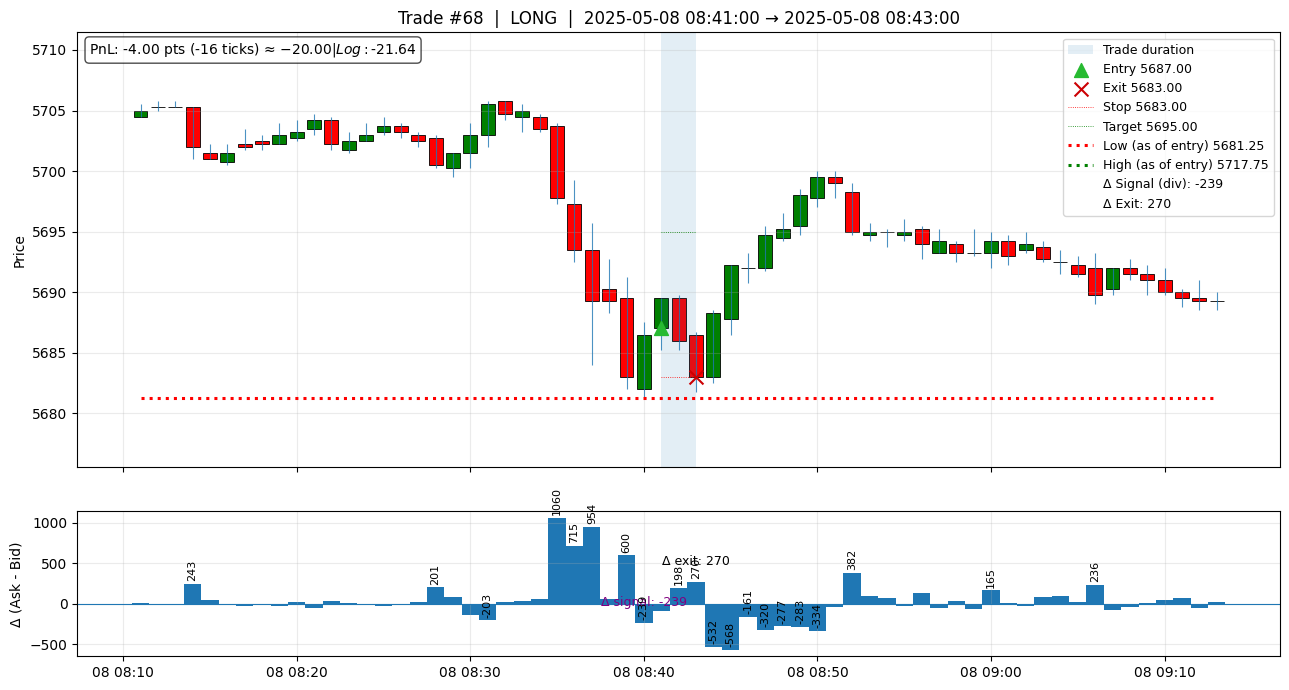

In [18]:
plot_trade(68, label_all_deltas=True,  delta_label_threshold=150)


### DRAFT

### MFE/MAE Analysis

In [ ]:
# # --- Construye trades a partir del log (ya definiste build_trades_from_log arriba)
# trades = build_trades_from_log(backtesting_base.profit).copy()
# # trades tiene: ['pos','side','t_in','p_in','stop','target','t_out','p_out','profit_exit_row']

# # Asegura tipos
# trades['t_in']  = pd.to_datetime(trades['t_in'])
# trades['t_out'] = pd.to_datetime(trades['t_out'])
# trades = trades.sort_values('t_in').reset_index(drop=True)

# # --- MFE/MAE por trade usando tu dataframe de barras 'df'
# TICK_SIZE = 0.25  # MES

# def mfe_mae_for_trade(row):
#     t0   = row['t_in']
#     t1   = row['t_out']
#     side = int(row['pos'])      # 1 = long, -1 = short
#     px0  = float(row['p_in'])

#     # Recorta las barras del trade (inclusivo)
#     sub = df.loc[(df.index >= t0) & (df.index <= t1)]
#     if sub.empty:
#         # fallback: incluye al menos la barra más cercana a entrada/salida
#         i0 = df.index.get_loc(df.index.asof(t0)) if hasattr(df.index, 'asof') else df.index.searchsorted(t0, side='left')
#         i1 = df.index.get_loc(df.index.asof(t1)) if hasattr(df.index, 'asof') else df.index.searchsorted(t1, side='right')-1
#         i0 = max(0, min(i0, len(df)-1))
#         i1 = max(0, min(i1, len(df)-1))
#         sub = df.iloc[min(i0,i1):max(i0,i1)+1]
#         if sub.empty:
#             return pd.Series({'MFE':0.0,'MAE':0.0,'TTMFE':pd.Timedelta(0),'Bars':0})

#     if side == 1:  # LONG
#         run_up   = sub['high'] - px0          # favorable
#         drawdown = sub['low']  - px0          # desfavorable (≤ 0)
#         mfe_val  = float(run_up.max())        # ≥ 0
#         mae_val  = float(drawdown.min())      # ≤ 0
#         ttmfe    = run_up.idxmax() - t0
#     else:          # SHORT
#         run_up   = px0 - sub['low']           # favorable
#         drawdown = px0 - sub['high']          # desfavorable (≤ 0)
#         mfe_val  = float(run_up.max())        # ≥ 0
#         mae_val  = float(drawdown.min())      # ≤ 0
#         ttmfe    = run_up.idxmax() - t0

#     return pd.Series({'MFE': mfe_val, 'MAE': mae_val, 'TTMFE': ttmfe, 'Bars': len(sub)})

# # Aplica la función
# mfe_mae = trades.apply(mfe_mae_for_trade, axis=1)
# trades_mfe = pd.concat([trades, mfe_mae], axis=1)

# # A ticks
# trades_mfe['MFE_ticks'] = trades_mfe['MFE'] / TICK_SIZE
# trades_mfe['MAE_ticks'] = trades_mfe['MAE'] / TICK_SIZE  # suele ser negativa

# # Resumen
# summary = trades_mfe[['MFE','MAE','MFE_ticks','MAE_ticks','TTMFE','Bars']].describe(percentiles=[.25,.5,.75,.9])
# summary


,MFE,MAE,MFE_ticks,MAE_ticks,TTMFE,Bars
count,217.000000,217.000000,217.000000,217.000000,217,218.000000
mean,5.548387,-4.422811,22.193548,-17.691244,0 days 00:09:56.958525345,17.091743
std,4.287008,3.239491,17.148031,12.957965,0 days 00:33:24.330488368,46.845573
min,0.000000,-29.500000,0.000000,-118.000000,0 days 00:00:00,2.000000
25%,1.750000,-5.500000,7.000000,-22.000000,0 days 00:00:00,2.000000
50%,4.500000,-4.250000,18.000000,-17.000000,0 days 00:01:00,5.000000
75%,8.750000,-2.250000,35.000000,-9.000000,0 days 00:07:00,11.000000
90%,10.750000,-1.000000,43.000000,-4.000000,0 days 00:23:24,33.000000
max,19.750000,0.000000,79.000000,0.000000,0 days 06:47:00,420.000000


In [ ]:
# p_hit_8  = (trades_mfe['MFE'] >= 8.0).mean()          # tasa de acierto a TP=8
# p_stop_4 = (trades_mfe['MAE'] <= -4.0).mean()         # prob. de tocar SL=4 (si no sales antes)
# exp_8_4  = p_hit_8*8 - (1-p_hit_8)*4                  # expectancy con TP=8, SL=4 (pts)

# print(p_hit_8, p_stop_4, exp_8_4)


0.38073394495412843 0.6284403669724771 0.5688073394495414


In [10]:
p_hit_4 = (trades_mfe['MFE'] >= 4).mean()
p_hit_4

np.float64(0.536697247706422)

### Comments

* Analyze MFE/MAE
* Add a break-even stop once price reaches +4 pts.
* Minimum Delta Threshold
* Test with more data
* filter it by just really strong delta divergences (strong price, volume, delta, ratio, etc)
* Analyze chart by chart and determine wy the winners win
* Try divergence and stack inbalance (at least 3 inbalances) after the divergence pattern
* Test other instruments

### Analysis Applied

* stop 5 target 10
    * 08 30  to 10 30 & 15 to 17 = - 100
    * 08 30 am to 10 30 am results = -177
    * 08 30 am to 11 00 am results = -548
    * 10 30 am to 12 00 pm results = -193
    * 08 30 to 5 pm = -629
* stop 4 target 8
    * 08 30  to 10 30 & 15 to 17 = 13 
    * 08 30 am to 10 30 am results = -110
    * 08 30 am to 11 00 am results = -497
    * 10 30 am to 12 00 pm results = -406
    * 08 30 to 5 pm = -588